In [1]:
import sys
sys.path.insert(0, '../../')

import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn

import pandas as pd

import ase

import time
import argparse

from models.descriptors import DihedralDescriptors, DistanceDescriptors

from models.basis_set_bias import BasisBias
from simulator.simple_diff_md import simulateNVTSystem, simulateNVTSystem_adjoint, simulateNVTSystem_warmup
from simulator.descriptor_loss import DescriptorLoss

from simulator.trainer import train_epoch

from simulator.adjoint_provider import get_adjoints

from models.gaussian_models import GridGaussians

from scipy.stats import chi2

from plotting.plot_intermediate import plot_intermediate

parser = argparse.ArgumentParser()
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument('--save_figs', action='store_true')
parser.add_argument('--no_adjoint', action='store_true')
parser.add_argument("--plot_every", default=1, type=int, help="When to plot figures.")

# Main simulation parameters
# Descriptor loss
parser.add_argument("--iterations", default=10000, type=int, help="Number of iterations to generate training data.")
parser.add_argument("--warmup", default=1200, type=int, help="Warm-up period for the trajectory termalization")
parser.add_argument("--backsteps", default=190, type=int, help="Number of backsteps. Must be smaller as warmup")
parser.add_argument("--plot_nth", default=10, type=int, help="Plotting every nth point.")


parser.add_argument("--batch_size", default=300, type=int, help="Batch size.")
parser.add_argument("--epochs", default=300, type=int, help="Number of training epochs.")
parser.add_argument("--save_steps", default=1, type=int, help="When to save tensor")
parser.add_argument("--dt", default=1.0, type=float, help="Timestep in fs")
parser.add_argument("--barrier", default=1.0, type=float, help="Barier size.")
parser.add_argument("--bias", default="descriptor_basis", type=str, help="Biased potential")
parser.add_argument("--dimension", default=5, type=int, help="Biased potential")
parser.add_argument("--neurons", default=150, type=int, help="Neurons in a net")
parser.add_argument("--loss", default="quad", type=str, help="Quadratic function")
parser.add_argument("--p_in_domain", default=0.1, type=float, help="Tolerance to it the target. Multiple of variance")

#Simulation controls
parser.add_argument("--temperature", default=300, type=float, help="System temperature.")
parser.add_argument("--gamma", default=0.1, type=float, help="Friction in langevin.")

#Training parameters
parser.add_argument("--learning_factor", default=3, type=float, help="Learning rate.")
parser.add_argument("--mini_batch", default=120, type=int, help="Mini batch")
parser.add_argument('--use_non_batched', action='store_true')
parser.add_argument('--device', default="cuda:0", type=str, help="Which device to use. CPU or GPU?")
parser.add_argument('--save_every_model', default=1, type=int, help="When to save the bias potential")
args = parser.parse_args("")

args.save_figs = True

/home/sipkam/anaconda3/envs/torchmdCUDA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define som runtimes stuff
if args.bias == "distance_basis":
    args.eps = args.eps/100
    
if args.save_steps > 1:
    raise NotImplemented("Feature not yet implemented and tested")

args.warmup = args.warmup//args.save_steps
args.backsteps = args.backsteps//args.save_steps

args.domain_tol = chi2.isf(args.p_in_domain, args.dimension)

#The numerical stability factor. Adjoints tend to be too small and numerical accuracy is an issue. 
adjoint_multiplier = 1e4


assert args.iterations > 3* args.warmup
assert args.backsteps < args.warmup
torch.manual_seed(args.seed)

if args.no_adjoint:
    forward_simulate = simulateNVTSystem
else:
    forward_simulate = simulateNVTSystem_adjoint


first_checkpoint = False
first_thr = 0.51
second_checkpoint = False
second_thr = 0.71
#third_checkpoint = True
#fourth_checkpoint = True


args.folder = "resultsAla2/"+args.bias+ "D" + str(args.dimension)+"p:"+str(args.p_in_domain)+"I:" \
    + str(args.iterations) \
    + "N"+ str(args.neurons) + "dt" + str(args.dt) + "T" + str(args.temperature) + "g" \
    + str(args.gamma) +"/"
isExist = os.path.exists(args.folder)

if not isExist and (args.save_figs or args.save_every_model > 0):
    os.makedirs(args.folder)
    print("making folder")

making folder


In [3]:
#Cell to design descriptors. Choose their type, periodicty and ranges. 

if args.dimension == 2:
    project_to = torch.tensor([0,1])
elif args.dimension == 5:
    project_to = torch.tensor([0,2])

#omega1, phi, psi, omega2, xi    
indices_dihedral = torch.tensor([
    [4,6,8,14],      #Phi
    [6,8,14,16],     #Psi
    [1,4,6,8],       #Omega 1
    [8,14,16,18],    #Omega 2
    [4,6,8,10]]).T   #Xi

indices_distance = torch.tensor([
    [1,18],  #Far C-C
    [1,16],  #far C-N
    [1,14],  #closer C-C
    [1,8],   #Backbone C-C
    [4,18],  #far C-C
    [4,16],  #closer C-N
    [4,14],  #close C-C
    [4,8],   #Backbone C-C
    [6,18],  #Far N-C
    [6,16],  # N-N 
    [6,14],  #close N-C
    [6,8],   #close N-C neigh
    #Include balast?
    [1,4],   
    [4,6],  
    [14,16],  
    [8,14],  
    [16,18],   
]).T




if args.bias == "dihedral_basis":   
    indices_dihedral = indices_dihedral[...,0:args.dimension]
    
if args.bias == "distance_basis":   
    indices_distance = indices_distance[...,0:args.dimension]
    #This part is just for plotting. These are known CVs for ala2 case. 
    indices_dihedral = indices_dihedral[...,0:2]
    

project_to = [0,1]
dihedral_descriptors = DihedralDescriptors(indices_dihedral, cv_index=project_to)
    
domain = {}
domain["Lx"], domain["Hx"] = -np.pi, np.pi
domain["Ly"], domain["Hy"] = -np.pi, np.pi
domain["res"] = 100

In [4]:
#Molecule loading and setup

from moleculekit.molecule import Molecule

#possible ase visualisation
import ase.io
from ase.visualize import view
from ase import Atoms

testdir = "../../data/ala2nowater/"

reactants = Molecule(os.path.join(testdir, "ala2nw.prmtop"))  # Reading the system topology
reactants.read(os.path.join(testdir, "reactants.coor"))  # Reading the initial simulation coordinates
reactants.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions
reactants.center(loc=(10.0,10.0,10.0))

products = Molecule(os.path.join(testdir, "ala2nw.prmtop"))  # Reading the system topology
products.read(os.path.join(testdir, "products.coor"))  # Reading the initial simulation coordinates
products.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions
products.center(loc=(10.0,10.0,10.0))



asemol = ase.io.read(os.path.join(testdir, "ala2.pdb"))
asemol.positions = reactants.coords.reshape(-1,3)
asemol.cell = reactants.box.reshape(3,)
asemol.pbc=True

#view(asemol)

In [5]:
#This is a forcefield setup

from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters
from simulator.system import System
from models.sample_forces import SampleForces
from functorch import vmap, jvp, vjp, grad

precision = torch.float

#Using all terms for the calculation
terms_to_use = SampleForces.terms

#Initialize the system and get ready
system = System(reactants.numAtoms, nreplicas=2*args.batch_size, precision=precision, device=args.device)
ff = ForceField.create(reactants, os.path.join(testdir, "ala2nw.prmtop"))
parameters = Parameters(ff, reactants, precision=precision, device=args.device)
parameters.mapped_atom_types = parameters.mapped_atom_types.to(args.device)
sample_forces = SampleForces(parameters, system.box, terms=terms_to_use)
system.M = sample_forces.par.masses.unsqueeze(0)

#Assign Coordinates
r_coords = torch.tensor(reactants.coords).repeat(1,1,args.batch_size)
p_coords = torch.tensor(products.coords).repeat(1,1,args.batch_size)
init_coordinates = torch.cat((r_coords,p_coords),dim=2)
init_coordinates_batchfirst = torch.permute(init_coordinates.detach(),(2,0,1))



In [6]:
#Define initialization and setup the run

from simulator.utils import maxwell_boltzmann, kinetic_energy, kinetic_to_temp, temp_to_kin

desired_kin = temp_to_kin(300, 3*system.M.shape[1])
    
def get_init_point(steps = 300):

    system.set_positions(init_coordinates.detach())
    system.set_box(reactants.box)
    system.set_velocities(maxwell_boltzmann(system.M, args.temperature, 3*system.M.shape[1], replicas=2*args.batch_size))
    kin = kinetic_energy(system.M, system.vel)
    factor = torch.sqrt(desired_kin/kin).reshape(-1,1,1).repeat(1,system.M.shape[1],1)
    system.vel = system.vel*factor

    system.to_(args.device)
    #Pass a vmap on the non-biased forces
    simulateNVTSystem_warmup(system, vmap(sample_forces.compute), args, steps=steps)
    
    kin = kinetic_energy(system.M, system.vel)

    start, end = system.pos.detach().chunk(2,dim=0)
    return system, torch.cat((start, end)), torch.cat((end, start))


get_init_point(10)
#Pass a vmap on a non-biased force
pos_list = simulateNVTSystem_warmup(system, vmap(sample_forces.compute), args, steps=1200)
#Stack the list of points and split into reactant trajs and product trajs
pos_list = torch.stack(pos_list, axis=1)
react_pos = pos_list[:args.batch_size]
prod_pos = pos_list[args.batch_size:]




In [7]:
if args.bias == "gauss":
    var = (np.pi/10)**2
    ranges = [[-np.pi, np.pi],[-np.pi, np.pi]]
    resolution = [10,10]
    sample_bias_force = GridGaussians(1.3, args.dimension, ranges, resolution, var=var, descriptors=get_descriptors, device=args.device)
    if args.use_non_batched or args.no_adjoint:
        lr = 0.1/adjoint_multiplier
    else:
        lr = 1/adjoint_multiplier
        
if args.bias == "descriptor_basis":   
    
    height = 1.3
    resolution = 50
    var = (np.pi/10)**2
    sample_bias_force = BasisBias(height,args.dimension, -np.pi, np.pi,
                                       resolution=resolution, var=var, neurons=args.neurons,
                                       descriptors=dihedral_descriptors, device=args.device)
    if args.use_non_batched or args.no_adjoint:
        lr = 0.1/adjoint_multiplier
    else:
        lr = args.learning_factor/adjoint_multiplier/args.batch_size    
       
    
    
sample_bias_force.to(args.device)
   
#Adam optimizer seems to work the best
optimizer = torch.optim.Adam(sample_bias_force.parameters(), lr=lr)

#Since we update scheduler only 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3)

#Descriptors
#descriptor_loss = DescriptorLoss(dihedral_descriptors, react_var_inv, prod_var_inv, args, traj_loss=False)

def unbiased_force(R):
    Epot, f_U = sample_forces.compute(R)
    return f_U

def sample_total_force(R):
       
    Epot, f_U = sample_forces.compute(R)   
    f_b = sample_bias_force.force_func(R)
    return f_U + f_b

def get_forces_vjp(R, vec):
    (_, vjpfunc) = vjp(sample_total_force, R)
    grad = vjpfunc(vec)[0]
    return grad

vmaped_unbiased = vmap(unbiased_force)
vmaped_force = vmap(sample_total_force)
vmaped_vjp = vmap(get_forces_vjp)

In [8]:
get_init_point()
trajectory, _, _ = forward_simulate(system, vmaped_unbiased, args)


sample_bias_force.load_state_dict(torch.load("model301.pt"))
get_init_point()
trajectory_conv, _, _ = forward_simulate(system, vmaped_force, args)

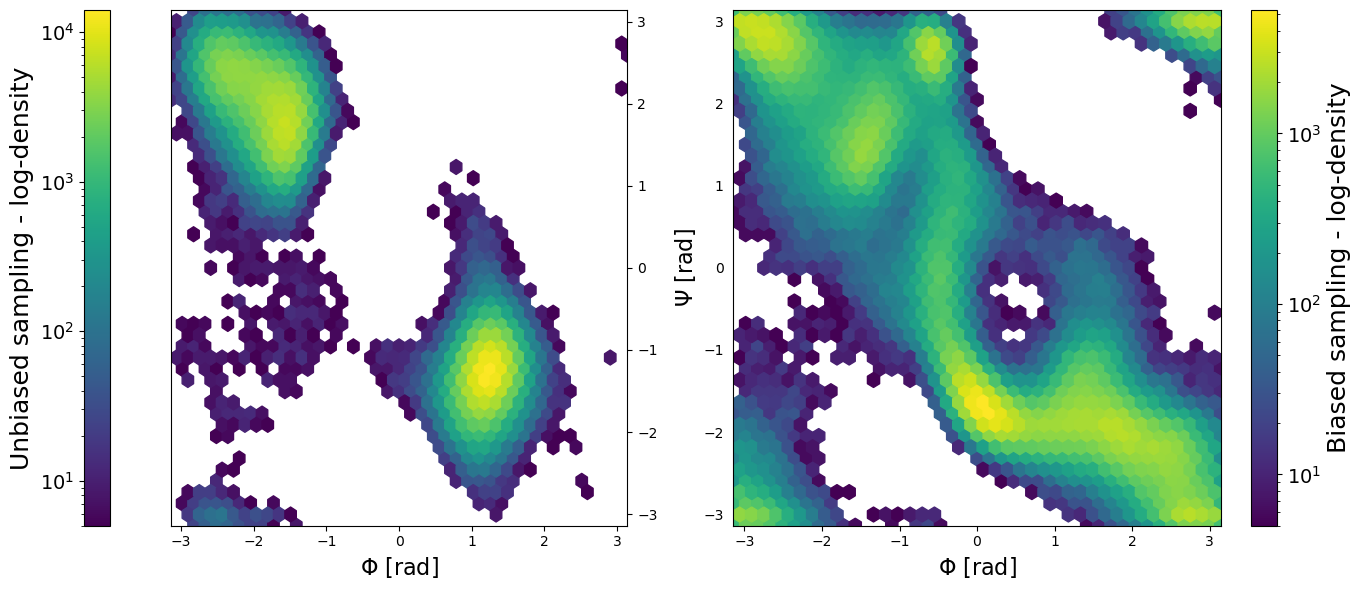

In [9]:
from scipy.interpolate import griddata

tick_font_size = 14
label_font_size = 18
mn = 5

traj_tensor = torch.stack(trajectory, axis=1)
traj_desc = dihedral_descriptors.get_descriptors(traj_tensor)   
known_cvs = dihedral_descriptors.get_descriptors(traj_tensor)[...,project_to]


Lx,Ly = domain["Lx"], domain["Ly"]
Hx,Hy = domain["Hx"], domain["Hy"]
resolution = domain["res"]

sample = traj_tensor[:,::args.plot_nth].reshape(-1, *traj_tensor.shape[2:])
desc_sample = traj_desc[:,::args.plot_nth].reshape(-1, *traj_desc.shape[2:])
cv_sample = known_cvs[:,::args.plot_nth].reshape(-1,2)

x, y = torch.meshgrid(torch.linspace(Lx, Hx, resolution), torch.linspace(Ly, Hy, resolution), indexing='ij')
x_dev, y_dev = x.to(args.device), y.to(args.device)

plt.figure(figsize = (14,6)) 
plt.subplot(121)

#z = potential.U_split(x_dev, y_dev).reshape((resolution,resolution)).detach().cpu()
#pot = plt.pcolormesh(x, y, z, cmap='magma', vmin=z.min(), vmax=10, shading='auto')
#cbar = plt.colorbar(pot, location="left")
#cbar.ax.set_ylabel('Potential [kcal/mol]',fontsize=13)

#plt.xlabel("x")
#plt.axis([Lx, Hx, Ly, Hy])

alpha = 1.0

plt.hexbin(cv_sample[:,0], cv_sample[:,1].detach().cpu(), bins="log", alpha=alpha, cmap="viridis",gridsize=40, mincnt=mn)
#plt.hexbin(cv_sample[:,0], cv_sample[:,1].detach().cpu(), bins=None, alpha=alpha, cmap="viridis",gridsize=40, mincnt=5)

cbar = plt.colorbar(location="left")
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.ax.set_ylabel('Unbiased sampling - log-density',fontsize=label_font_size)
plt.axis([Lx, Hx, Ly, Hy])

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=True,
    labelbottom=True,
    labelleft=False,
    labelright=True) # labels along the bottom edge are off

plt.xlabel("$\Phi$ [rad]", fontsize=16)

plt.subplot(122)

traj_tensor = torch.stack(trajectory_conv, axis=1)
traj_desc = dihedral_descriptors.get_descriptors(traj_tensor)   
known_cvs = dihedral_descriptors.get_descriptors(traj_tensor)[...,project_to]

sample = traj_tensor[:,::args.plot_nth].reshape(-1, *traj_tensor.shape[2:])
desc_sample = traj_desc[:,::args.plot_nth].reshape(-1, *traj_desc.shape[2:])
cv_sample = known_cvs[:,::args.plot_nth].reshape(-1,2)

x, y = torch.meshgrid(torch.linspace(Lx, Hx, resolution), torch.linspace(Ly, Hy, resolution), indexing='ij')
x_dev, y_dev = x.to(args.device), y.to(args.device)

#z = potential.U_split(x_dev, y_dev).reshape((resolution,resolution)).detach().cpu()
#pot = plt.pcolormesh(x, y, z, cmap='magma', vmin=z.min(), vmax=10, shading='auto')
#cbar = plt.colorbar(pot, location="left")
#cbar.ax.set_ylabel('Potential [kcal/mol]',fontsize=13)

#plt.xlabel("x")
plt.axis([Lx, Hx, Ly, Hy])

alpha = 1.0

plt.hexbin(cv_sample[:,0], cv_sample[:,1].detach().cpu(), bins="log", alpha=alpha, cmap="viridis",gridsize=40, mincnt=mn)
#plt.hexbin(cv_sample[:,0], cv_sample[:,1].detach().cpu(), bins=None, alpha=alpha, cmap="viridis",gridsize=40, mincnt=5)
cbar2 = plt.colorbar(location="right")
cbar2.ax.tick_params(labelsize=tick_font_size)
cbar2.ax.set_ylabel('Biased sampling - log-density',fontsize=label_font_size)
plt.axis([Lx, Hx, Ly, Hy])

plt.xlabel("$\Phi$ [rad]", fontsize=16)
plt.ylabel("$\Psi$ [rad]", fontsize=16)


plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=True,
    labelleft=True,
    labelright=False) # labels along the bottom edge are off

plt.tight_layout()

fig = plt.gcf()
fig.savefig("initial_density")
plt.show()
plt.close()

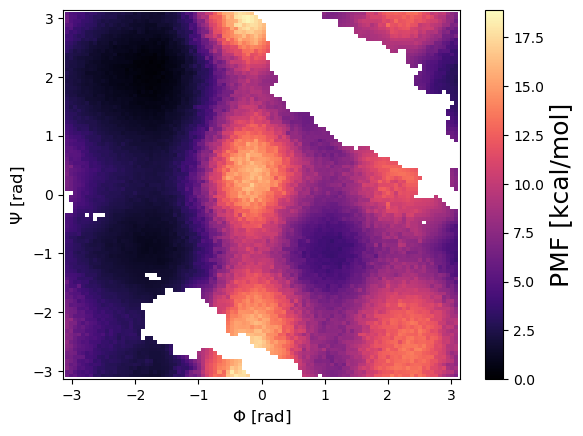

In [15]:
from scipy.spatial import cKDTree
from scipy.interpolate.interpnd import _ndim_coords_from_arrays

THRESHOLD = 0.15

bias = sample_bias_force.bias_from_desc(sample.requires_grad_(True).to(args.device)).detach().cpu()
fes = -bias
fes = fes - fes.min()

points = torch.stack((cv_sample[:,0], cv_sample[:,1]), axis=-1).detach().cpu()

z_b = griddata(points, fes, (x, y), method='linear')

tree = cKDTree(points)

xi = _ndim_coords_from_arrays((x,y), ndim=points.shape[1])
dists, indexes = tree.query(xi)

z_b[dists > THRESHOLD] = np.nan


B_min, B_max = fes.min(), fes.max()
#B_min, B_max = 0, 35.0

#print(z_b)

c_bias = plt.pcolormesh(x, y, z_b, cmap='magma', vmin=B_min, vmax=B_max, shading='auto')
cbar = plt.colorbar(c_bias, label="Bias potential [kcal/mol]")
plt.axis([Lx, Hx, Ly, Hy])

plt.xlabel("$\Phi$ [rad]", fontsize=12)
plt.ylabel("$\Psi$ [rad]", fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('PMF [kcal/mol]',fontsize=label_font_size)

fig = plt.gcf()
fig.savefig("final_bias")
plt.show()
plt.close()

In [ ]:
#Possibly take a look at the trajector in ASE

def get_ase_traj(traj_tensor):
    #Let us look at mol 0
    single_traj = traj_tensor[-1]
    ase_traj = []
    for im in single_traj:
        frame = asemol.copy()
        frame.positions = im
        ase_traj.append(frame)
        
    ase.io.write("resulting_traj.traj", ase_traj, format="traj")

get_ase_traj(traj_tensor)


In [ ]:
print(i)
known_descs = known_cvs.detach().cpu().reshape(-1,2)
plt.hexbin(known_descs[::10,0], known_descs[::10,1].detach().cpu(), cmap="viridis",gridsize=40, mincnt=5)
plt.colorbar()
plt.show()